# Web Voyager

[WebVoyager](https://arxiv.org/abs/2401.13919) by He, et. al., is a vision-enabled web-browsing agent capable of controlling the mouse and keyboard.

It works by viewing annotated browser screenshots for each turn, then choosing the next step to take. The agent architecture is a basic reasoning and action (ReAct) loop. 
The unique aspects of this agent are:
- It's usage of [Set-of-Marks](https://som-gpt4v.github.io/)-like image annotations to serve as UI affordances for the agent
- It's application in the browser by using tools to control both the mouse and keyboard

The overall design looks like the following:

<img src="./img/web-voyager.excalidraw.jpg" src="../img/web-voyager.excalidraw.jpg" >

## Setup

First, let's install our required packages:

In [1]:
import os
from dotenv import load_dotenv

# 載入 .env 檔案中的環境變數
load_dotenv()

# 取得 API 金鑰
api_key = os.getenv("OPENAI_API_KEY")

# 確保 API 金鑰存在
if not api_key:
    raise ValueError("OPENAI_API_KEY is not set in the environment or .env file.")

print("API Key Loaded Successfully")


API Key Loaded Successfully


<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

#### Install Agent requirements

The only additional requirement we have is the [playwright](https://playwright.dev/) browser. Uncomment and install below:

In [2]:
import nest_asyncio

# This is just required for running async playwright in a Jupyter notebook
nest_asyncio.apply()

## Helper File

We will use some JS code for this tutorial, which you should place in a file called `mark_page.js` in the same directory as the notebook you are running this tutorial from.

<div>
  <button type="button" style="border: 1px solid black; border-radius: 5px; padding: 5px; background-color: lightgrey;" onclick="toggleVisibility('helper-functions')">Show/Hide JS Code</button>
  <div id="helper-functions" style="display:none;">
    <!-- Helper functions -->
    <pre>

    const customCSS = `
        ::-webkit-scrollbar {
            width: 10px;
        }
        ::-webkit-scrollbar-track {
            background: #27272a;
        }
        ::-webkit-scrollbar-thumb {
            background: #888;
            border-radius: 0.375rem;
        }
        ::-webkit-scrollbar-thumb:hover {
            background: #555;
        }
    `;

    const styleTag = document.createElement("style");
    styleTag.textContent = customCSS;
    document.head.append(styleTag);

    let labels = [];

    function unmarkPage() {
    // Unmark page logic
    for (const label of labels) {
        document.body.removeChild(label);
    }
    labels = [];
    }

    function markPage() {
    unmarkPage();

    var bodyRect = document.body.getBoundingClientRect();

    var items = Array.prototype.slice
        .call(document.querySelectorAll("*"))
        .map(function (element) {
        var vw = Math.max(
            document.documentElement.clientWidth || 0,
            window.innerWidth || 0
        );
        var vh = Math.max(
            document.documentElement.clientHeight || 0,
            window.innerHeight || 0
        );
        var textualContent = element.textContent.trim().replace(/\s{2,}/g, " ");
        var elementType = element.tagName.toLowerCase();
        var ariaLabel = element.getAttribute("aria-label") || "";

        var rects = [...element.getClientRects()]
            .filter((bb) => {
            var center_x = bb.left + bb.width / 2;
            var center_y = bb.top + bb.height / 2;
            var elAtCenter = document.elementFromPoint(center_x, center_y);

            return elAtCenter === element || element.contains(elAtCenter);
            })
            .map((bb) => {
            const rect = {
                left: Math.max(0, bb.left),
                top: Math.max(0, bb.top),
                right: Math.min(vw, bb.right),
                bottom: Math.min(vh, bb.bottom),
            };
            return {
                ...rect,
                width: rect.right - rect.left,
                height: rect.bottom - rect.top,
            };
            });

        var area = rects.reduce((acc, rect) => acc + rect.width * rect.height, 0);

        return {
            element: element,
            include:
            element.tagName === "INPUT" ||
            element.tagName === "TEXTAREA" ||
            element.tagName === "SELECT" ||
            element.tagName === "BUTTON" ||
            element.tagName === "A" ||
            element.onclick != null ||
            window.getComputedStyle(element).cursor == "pointer" ||
            element.tagName === "IFRAME" ||
            element.tagName === "VIDEO",
            area,
            rects,
            text: textualContent,
            type: elementType,
            ariaLabel: ariaLabel,
        };
        })
        .filter((item) => item.include && item.area >= 20);

    // Only keep inner clickable items
    items = items.filter(
        (x) => !items.some((y) => x.element.contains(y.element) && !(x == y))
    );

    // Function to generate random colors
    function getRandomColor() {
        var letters = "0123456789ABCDEF";
        var color = "#";
        for (var i = 0; i < 6; i++) {
        color += letters[Math.floor(Math.random() * 16)];
        }
        return color;
    }

    // Lets create a floating border on top of these elements that will always be visible
    items.forEach(function (item, index) {
        item.rects.forEach((bbox) => {
        newElement = document.createElement("div");
        var borderColor = getRandomColor();
        newElement.style.outline = `2px dashed ${borderColor}`;
        newElement.style.position = "fixed";
        newElement.style.left = bbox.left + "px";
        newElement.style.top = bbox.top + "px";
        newElement.style.width = bbox.width + "px";
        newElement.style.height = bbox.height + "px";
        newElement.style.pointerEvents = "none";
        newElement.style.boxSizing = "border-box";
        newElement.style.zIndex = 2147483647;
        // newElement.style.background = `${borderColor}80`;

        // Add floating label at the corner
        var label = document.createElement("span");
        label.textContent = index;
        label.style.position = "absolute";
        // These we can tweak if we want
        label.style.top = "-19px";
        label.style.left = "0px";
        label.style.background = borderColor;
        // label.style.background = "black";
        label.style.color = "white";
        label.style.padding = "2px 4px";
        label.style.fontSize = "12px";
        label.style.borderRadius = "2px";
        newElement.appendChild(label);

        document.body.appendChild(newElement);
        labels.push(newElement);
        // item.element.setAttribute("-ai-label", label.textContent);
        });
    });
    const coordinates = items.flatMap((item) =>
        item.rects.map(({ left, top, width, height }) => ({
        x: (left + left + width) / 2,
        y: (top + top + height) / 2,
        type: item.type,
        text: item.text,
        ariaLabel: item.ariaLabel,
        }))
    );
    return coordinates;
    }


</pre>
  </div>
</div>

<script>
  function toggleVisibility(id) {
    var element = document.getElementById(id);
    element.style.display = (element.style.display === "none") ? "block" : "none";
  }
</script>

## Define graph

### Define graph state

The state provides the inputs to each node in the graph.

In our case, the agent will track the webpage object (within the browser), annotated images + bounding boxes, the user's initial request, and the messages containing the agent scratchpad, system prompt, and other information.


In [3]:
from typing import List, Optional
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage, SystemMessage
from playwright.async_api import Page


class BBox(TypedDict):
    x: float
    y: float
    text: str
    type: str
    ariaLabel: str


class Prediction(TypedDict):
    action: str
    args: Optional[List[str]]


# This represents the state of the agent
# as it proceeds through execution
class AgentState(TypedDict):
    page: Page  # The Playwright web page lets us interact with the web environment
    input: str  # User request
    img: str  # b64 encoded screenshot
    bboxes: List[BBox]  # The bounding boxes from the browser annotation function
    prediction: Prediction  # The Agent's output
    # A system message (or messages) containing the intermediate steps
    scratchpad: List[BaseMessage]
    observation: str  # The most recent response from a tool

### Define tools

The agent has 6 simple tools:

1. Click (at labeled box)
2. Type
3. Scroll
4. Wait
5. Go back
6. Go to search engine (Google)


We define them below here as functions:

In [4]:
import asyncio
import platform


async def click(state: AgentState):
    # - Click [Numerical_Label]
    page = state["page"]
    click_args = state["prediction"]["args"]
    if click_args is None or len(click_args) != 1:
        return f"Failed to click bounding box labeled as number {click_args}"
    bbox_id = click_args[0]
    bbox_id = int(bbox_id)
    try:
        bbox = state["bboxes"][bbox_id]
    except Exception:
        return f"Error: no bbox for : {bbox_id}"
    x, y = bbox["x"], bbox["y"]
    await page.mouse.click(x, y)
    # TODO: In the paper, they automatically parse any downloaded PDFs
    # We could add something similar here as well and generally
    # improve response format.
    return f"Clicked {bbox_id}"


async def type_text(state: AgentState):
    page = state["page"]
    type_args = state["prediction"]["args"]
    if type_args is None or len(type_args) != 2:
        return (
            f"Failed to type in element from bounding box labeled as number {type_args}"
        )
    bbox_id = type_args[0]
    bbox_id = int(bbox_id)
    bbox = state["bboxes"][bbox_id]
    x, y = bbox["x"], bbox["y"]
    text_content = type_args[1]
    await page.mouse.click(x, y)
    # Check if MacOS
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(text_content)
    await page.keyboard.press("Enter")
    return f"Typed {text_content} and submitted"


async def scroll(state: AgentState):
    page = state["page"]
    scroll_args = state["prediction"]["args"]
    if scroll_args is None or len(scroll_args) != 2:
        return "Failed to scroll due to incorrect arguments."

    target, direction = scroll_args

    if target.upper() == "WINDOW":
        # Not sure the best value for this:
        scroll_amount = 500
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
    else:
        # Scrolling within a specific element
        scroll_amount = 200
        target_id = int(target)
        bbox = state["bboxes"][target_id]
        x, y = bbox["x"], bbox["y"]
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.mouse.move(x, y)
        await page.mouse.wheel(0, scroll_direction)

    return f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"


async def wait(state: AgentState):
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return f"Waited for {sleep_time}s."


async def go_back(state: AgentState):
    page = state["page"]
    await page.go_back()
    return f"Navigated back a page to {page.url}."

async def to_youtube(state: AgentState):
    page = state["page"]
    await page.goto("https://www.youtube.com/")
    return "Navigated to youtube.com."

### Define Agent

The agent is driven by a multi-modal model and decides the action to take for each step. It is composed of a few runnable objects:

1. A `mark_page` function to annotate the current page with bounding boxes
2. A prompt to hold the user question, annotated image, and agent scratchpad
3. GPT-4V to decide the next steps
4. Parsing logic to extract the action


Let's first define the annotation step:
#### Browser Annotations

This function annotates all buttons, inputs, text areas, etc. with numbered bounding boxes. GPT-4V then just has to refer to a bounding box
when taking actions, reducing the complexity of the overall task.

In [5]:
import base64

from langchain_core.runnables import chain as chain_decorator

# Some javascript we will run on each step
# to take a screenshot of the page, select the
# elements to annotate, and add bounding boxes
with open("mark_page.js") as f:
    mark_page_script = f.read()


@chain_decorator
async def mark_page(page):
    await page.evaluate(mark_page_script)
    for _ in range(10):
        try:
            bboxes = await page.evaluate("markPage()")
            break
        except Exception:
            # May be loading...
            asyncio.sleep(3)
    screenshot = await page.screenshot()
    # Ensure the bboxes don't follow us around
    await page.evaluate("unmarkPage()")
    return {
        "img": base64.b64encode(screenshot).decode(),
        "bboxes": bboxes,
    }

#### Agent definition

Now we'll compose this function with the prompt, llm and output parser to complete our agent.

In [6]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI


async def annotate(state):
    marked_page = await mark_page.with_retry().ainvoke(state["page"])
    return {**state, **marked_page}


def format_descriptions(state):
    labels = []
    for i, bbox in enumerate(state["bboxes"]):
        text = bbox.get("ariaLabel") or ""
        if not text.strip():
            text = bbox["text"]
        el_type = bbox.get("type")
        labels.append(f'{i} (<{el_type}/>): "{text}"')
    bbox_descriptions = "\nValid Bounding Boxes:\n" + "\n".join(labels)
    return {**state, "bbox_descriptions": bbox_descriptions}


def parse(text: str) -> dict:
    action_prefix = "Action: "
    if not text.strip().split("\n")[-1].startswith(action_prefix):
        return {"action": "retry", "args": f"Could not parse LLM Output: {text}"}
    action_block = text.strip().split("\n")[-1]

    action_str = action_block[len(action_prefix) :]
    split_output = action_str.split(" ", 1)
    if len(split_output) == 1:
        action, action_input = split_output[0], None
    else:
        action, action_input = split_output
    action = action.strip()
    if action_input is not None:
        action_input = [
            inp.strip().strip("[]") for inp in action_input.strip().split(";")
        ]
    return {"action": action, "args": action_input}


# Will need a later version of langchain to pull
# this image prompt template
prompt = hub.pull("wfh/web-voyager")

/Users/kslab-macstudio/miniconda3/envs/agent/lib/python3.12/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [7]:
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnableLambda


'''llm = ChatOllama(
    model="gemma3:27b",
    temperature=0,
    # other params...
)'''

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    max_tokens=4096,
    timeout=None,
    max_retries=2,
)

# 將 prompt 字串包裝成 RunnableLambda
prompt_runnable = RunnableLambda(lambda state: prompt)

agent = annotate | RunnablePassthrough.assign(
    prediction=format_descriptions | prompt_runnable | llm | StrOutputParser() | parse
)

## Compile the graph

We've created most of the important logic. We have one more function to define that will help us update the graph state after a tool is called.

In [8]:
import re

def update_scratchpad(state: AgentState):
    """After a tool is invoked, we want to update
    the scratchpad so the agent is aware of its previous steps"""
    old = state.get("scratchpad")
    if old:
        txt = old[0].content
        last_line = txt.rsplit("\n", 1)[-1]
        step = int(re.match(r"\d+", last_line).group()) + 1
    else:
        txt = "Previous action observations:\n"
        step = 1
    txt += f"\n{step}. {state['observation']}"

    return {**state, "scratchpad": [SystemMessage(content=txt)]}

Now we can compose everything into a graph:

In [9]:
from langchain_core.runnables import RunnableLambda

from langgraph.graph import END, START, StateGraph

graph_builder = StateGraph(AgentState)


graph_builder.add_node("agent", agent)
graph_builder.add_edge(START, "agent")

graph_builder.add_node("update_scratchpad", update_scratchpad)
graph_builder.add_edge("update_scratchpad", "agent")

tools = {
    "Click": click,
    "Type": type_text,
    "Scroll": scroll,
    "Wait": wait,
    "GoBack": go_back,
    "Youtube": to_youtube,
}


for node_name, tool in tools.items():
    graph_builder.add_node(
        node_name,
        # The lambda ensures the function's string output is mapped to the "observation"
        # key in the AgentState
        RunnableLambda(tool) | (lambda observation: {"observation": observation}),
    )
    # Always return to the agent (by means of the update-scratchpad node)
    graph_builder.add_edge(node_name, "update_scratchpad")


def select_tool(state: AgentState):
    # Any time the agent completes, this function
    # is called to route the output to a tool or
    # to the end user.
    action = state["prediction"]["action"]
    if action == "ANSWER":
        return END
    if action == "retry":
        return "agent"
    return action


graph_builder.add_conditional_edges("agent", select_tool)

graph = graph_builder.compile()

## Use the graph

Now that we've created the whole agent executor, we can run it on a few questions! We'll start our browser at "google.com" and then let it control the rest.

Below is a helper function to help print out the steps to the notebook (and display the intermediate screenshots).

In [10]:
from IPython.display import clear_output, display, Image
from playwright.async_api import async_playwright

browser = await async_playwright().start()
# We will set headless=False so we can watch the agent navigate the web.
browser = await browser.chromium.launch(headless=True, args=None)
page = await browser.new_page()
_ = await page.goto("https://www.youtube.com/")


async def call_agent(question: str, page, max_steps: int = 150):
    event_stream = graph.astream(
        {
            "page": page,
            "input": question,
            "scratchpad": [],
        },
        {
            "recursion_limit": max_steps,
        },
    )
    final_answer = None
    steps = []
    async for event in event_stream:
        # We'll display an event stream here
        if "agent" not in event:
            continue
        pred = event["agent"].get("prediction") or {}
        action = pred.get("action")
        action_input = pred.get("args")
        clear_output(wait=False)
        steps.append(f"{len(steps) + 1}. {action}: {action_input}")
        print("\n".join(steps))
        display(Image(base64.b64decode(event["agent"]["img"])))
        if "ANSWER" in action:
            final_answer = action_input[0]
            break
    return final_answer

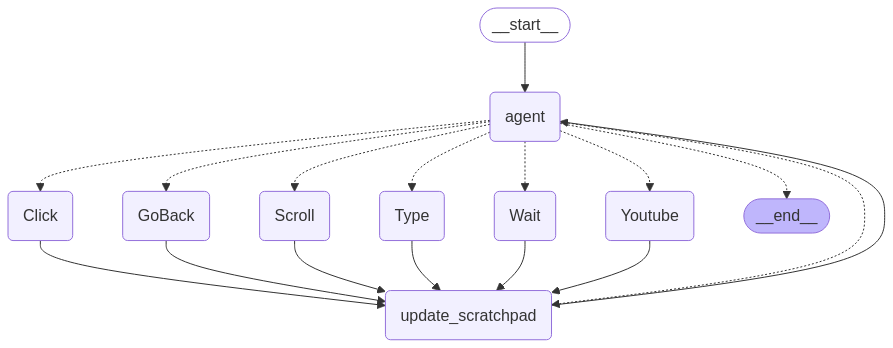

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

1. Type: ['2', '游庭皓的財經皓角']
2. Click: ['4']


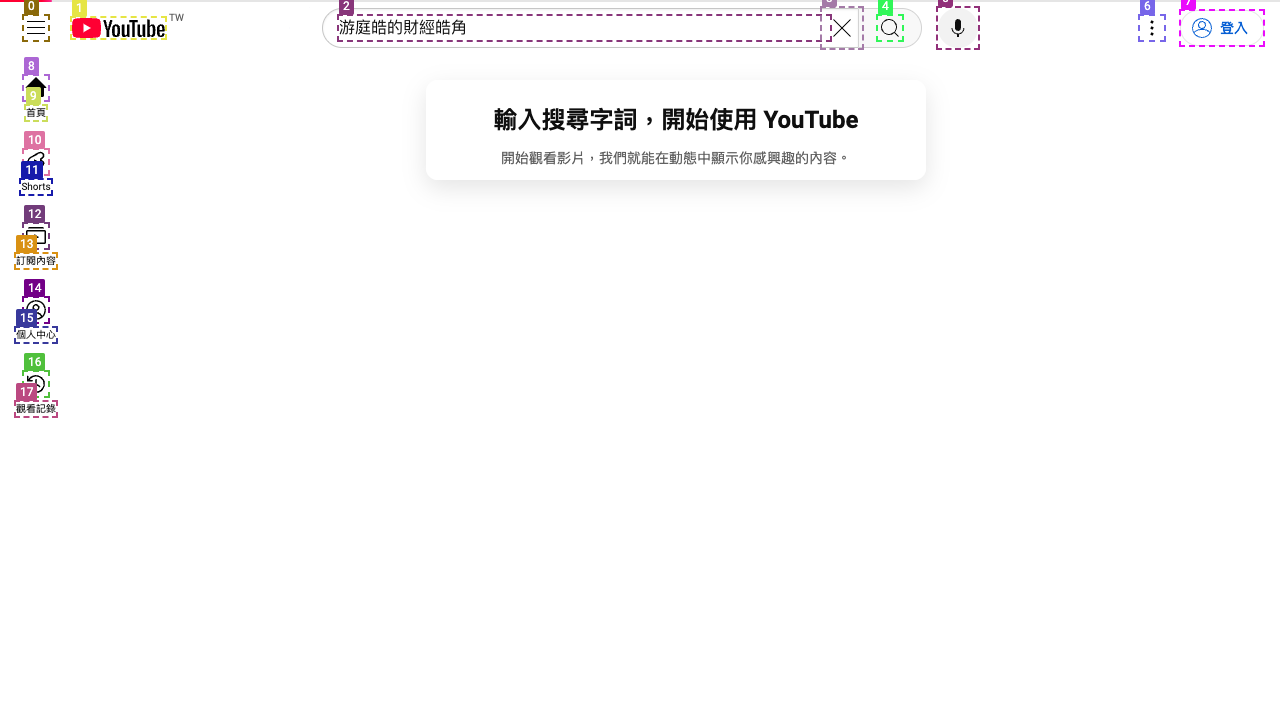

In [ ]:
res = await call_agent(
    """
1. 打開 YouTube：使用 "youtube" 工具前往 YouTube 首頁。
2. 搜尋頻道：在搜尋欄輸入「游庭皓的財經皓角」，並從搜尋結果中點擊對應頻道。
3. 瀏覽直播影片：在頻道主頁上瀏覽影片列表，並向下滾動以載入更多內容，找到過去一個禮拜內所有的直播影片。
4. 逐一點擊直播影片：對於每個找到的直播影片，點擊進入影片播放頁面。
5. 按下「分享」按鈕：進入影片播放頁面後，點擊「分享」按鈕，讓分享連結彈出。
6. 複製分享連結：從彈出視窗中複製該直播影片的分享連結，並儲存此連結。
7. 返回頻道主頁：複製完連結後，返回頻道主頁以便處理下一個直播影片。
8. 重複步驟 4 至 7，直到所有過去一個禮拜內的直播影片連結皆被複製完畢。

注意：由於網頁可能因網速或其他因素載入較慢，請耐心等待每個步驟完成，確保所有直播影片的連結都被正確複製。
    """,
    page
)
print(f"Final response: {res}")


In [ ]:
import re
import yt_dlp

def download_video_from_res(res: str):
    """
    從給定的字串 res 中提取 URL，並使用 yt-dlp 下載影片。
    """
    # 利用正則表達式尋找 URL
    match = re.search(r'(https?://\S+)', res)
    if not match:
        print("找不到有效的 URL。")
        return
    
    url = match.group(1)
    print("提取到的 URL:", url)
    
    # 設定 yt-dlp 的選項
    ydl_opts = {
        "outtmpl": "%(title)s.%(ext)s",  # 使用影片標題作為檔名
        "quiet": False,                 # 可調整是否顯示下載進程
        "format": "best",               # 下載最佳質量的影片
    }
    
    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([url])
        print("下載完成。")
    except Exception as e:
        print("下載過程中發生錯誤:", e)

# 測試範例
# res = "Use the link provided to download the video using a suitable tool. Here is the copied link: https://www.youtube.com/live/NWAwGK37Dd4?s=i"
download_video_from_res(res)
